In [6]:
def extract_actions(single_history):
    """
    Takes a single string of history (no /) and 
    returns a list of actions in a form such as
    ['c', '1r', '10r', 'f']
    """
    actions = []
    current_action = ''
    for item in single_history:
        if item in ['a', 'c', 'f']:
            actions.append(item)
            current_action = ''
        elif item.isdigit():
            current_action += item
        elif item == 'r':
            actions.append(current_action + item)
            current_action = ''
    return actions
            

def player_money_bet(action_history):
    """
    Returns the amount of money p1 and p2 have bet
    (not including the antee) with the format of p1, p2.
    Assumes that player 1 always moves first for each betting round.
    """
    p1_commited = 0
    p2_commited = 0
    for history in action_history:
        print(history)
        p1_temp = 0
        p2_temp = 0
        for key, action in enumerate(extract_actions(history)):
            if key % 2 == 0:
                if action == 'c':
                    p1_temp = p2_temp
                elif 'r' in action:
                    p1_temp = p2_temp + int(action.replace('r', ''))
                elif action == 'a':
                    p1_temp += 1
            else:
                if action == 'c':
                    p2_temp = p1_temp
                elif 'r' in action:
                    p2_temp = p1_temp + int(action.replace('r', ''))
                elif action == 'a':
                    p2_temp += 1
        print(p1_temp, p2_temp)
        p1_commited += p1_temp
        p2_commited += p2_temp
    
    return p1_commited, p2_commited

def valid_actions(infoset_key, max_bet):
    """
    Returns a list of valid actions based off the tree history.
    """
    player_id = infoset_key.split(";")[0]
    action_history = infoset_key.split(";")[-1].split('/')

    p1_commited, p2_commited = player_money_bet(action_history)
    if p1_commited > max_bet or p2_commited > max_bet:
        error_msg = f"P1 or P2 have bet too much money! p1_commited: {p1_commited} and p2_commited: {p2_commited}"
        error_msg += f" with a max bet of {max_bet}"
        raise ValueError(error_msg)

    print(p1_commited, p2_commited)
    actions = ['c']
    if player_id == "P1":
        if p2_commited > p1_commited: # Being raised against
            actions = ['f'] + actions
        for bet_amount in range(1, max_bet + 1 - p2_commited):
            actions.append(str(bet_amount) + 'r')

    if player_id == "P2":
        if p1_commited > p2_commited: # Being raised against
            actions = ['f'] + actions
        for bet_amount in range(1, max_bet + 1 - p1_commited):
            actions.append(str(bet_amount) + 'r')

    return actions

class Card:
    SUIT_TO_STRING = {
        1: "s",
        2: "h",
        3: "d",
        4: "c"
    }
    
    RANK_TO_STRING = {
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
        10: "T",
        11: "J",
        12: "Q",
        13: "K",
        14: "A"
    }

    RANK_JACK = 11
    RANK_QUEEN = 12
    RANK_KING = 13
    RANK_ACE = 14
    
    STRING_TO_SUIT = dict([(v, k) for k, v in SUIT_TO_STRING.items()])
    STRING_TO_RANK = dict([(v, k) for k, v in RANK_TO_STRING.items()])

    def __init__(self, rank, suit):
        """
        Create a card. Rank is 2-14, representing 2 through Ace,
        while suit is 1-4 representing spades, hearts, diamonds, clubs
        """
        self.rank = rank
        self.suit = suit

    def __repr__(self):
        return "(%s, %s)" % (self.rank, self.suit)
    
    def pretty_repr(self):
        return "%s%s" % (self.RANK_TO_STRING[self.rank], self.SUIT_TO_STRING[self.suit])
    
    def __eq__(self, other):
        return (isinstance(other, self.__class__) and self.rank == other.rank and self.suit == other.suit)
    
    def __hash__(self):
        return hash((self.rank, self.suit))

def evaluate_winner_ac(cards_1, cards_2, community_cards, history):
    """
    This function returns 1, 0, or -1 for player winning,
    tieing, or losing.
    """
    
    print(",".join([x.pretty_repr() for x in cards_1]))
    print(",".join([x.pretty_repr() for x in cards_2]))
    print(",".join([x.pretty_repr() for x in community_cards]))

    # Check for folding
    final_history = history[-1]
    if len(final_history) > 0 and final_history[-1] == 'f':
        if len(final_history) % 2 == 0:
            return 1
        else:
            return 2

    def get_best_card(cards):
        best_card = Card(-1, -1)
        for card in cards:
            if card.rank > best_card.rank:
                best_card = card
            elif card.rank == best_card.rank and card.suit > best_card.suit:
                best_card = card
        return best_card

    # Assuming no one folded, evaluate based on high card
    p1_best_card = get_best_card(cards_1)
    p2_best_card = get_best_card(cards_2)

    print("p1_best_card", p1_best_card)
    print("p2_best_card", p2_best_card)
    
    if p1_best_card.rank > p2_best_card.rank:
        return 1
    elif p2_best_card.rank > p1_best_card.rank:
        return 2
    elif p1_best_card.rank == p2_best_card.rank:
        if p1_best_card.suit > p2_best_card.suit:
            return 1
        else:
            return 2

def terminal_util(infoset_key, p1_cards, p2_cards, co_cards, player_id):
    """
    Returns the utility of a terminal history.
    All action has finished, payouts are determined.
    """

    action_history = infoset_key.split(";")[-1].split('/')

    p1_commited, p2_commited = player_money_bet(action_history)
    winner = evaluate_winner(p1_cards, p2_cards, co_cards, action_history)

    if winner == -1: # Tie
        return 0

    if player_id == "P1":
        if winner == 1:
            return p2_commited
        else:
            return -1 * p1_commited
    if player_id == "P2":
        if winner == 2:
            return p1_commited
        else:
            return -1 * p2_commited

def estimate_hand_strength(player_cards, co_cards, deck):
    simulation_results = []

    for i in range(_NB_SIMULATION):
        opponents_cards, new_deck = deck.draw_random_cards(2)
        new_community_cards, final_deck = new_deck.draw_random_cards(5 - len(co_cards))
        community_cards = sort_cards(co_cards + new_community_cards)
        dummy_history = ['cc']
        winner = evaluate_winner(player_cards, opponents_cards, community_cards, dummy_history)

        if winner == 1: #player wins
            result = 1
        else:
            result = 0

        simulation_results.append(result)
    average_win_rate = sum(simulation_results) / len(simulation_results)
      
    return average_win_rate

def evaluate_winner(cards_1, cards_2, community_cards, history):
    """
    This function returns 1, 0, or -1 for player winning,
    tieing, or losing.
    """
    
    # Check for folding
    final_history = extract_actions(history[-1])
    if len(final_history) > 0 and final_history[-1] == 'f':
        if len(final_history) % 2 == 0:
            return 1
        else:
            return 2

    def get_best_card(cards):
        best_card = Card(-1, -1)
        for card in cards:
            if card.rank > best_card.rank:
                best_card = card
            elif card.rank == best_card.rank and card.suit > best_card.suit:
                best_card = card
        return best_card

    # Assuming no one folded, evaluate based on high card
    p1_best_card = get_best_card(cards_1)
    p2_best_card = get_best_card(cards_2)
    
    if p1_best_card.rank > p2_best_card.rank:
        return 1
    elif p2_best_card.rank > p1_best_card.rank:
        return 2
    elif p1_best_card.rank == p2_best_card.rank:
        if p1_best_card.suit > p2_best_card.suit:
            return 1
        else:
            return 2

#print(valid_actions("P2;3/4;aa/cc/c1r1r", 3))

# player_id = 'P2'
# p1_cards = (Card(5,1), Card(2,1))
# p2_cards = (Card(4,1), Card(4,2))
# community_cards = [(Card(3,2))]
# action_history = ['1rf']

# print(evaluate_winner(p1_cards, p2_cards, community_cards, action_history))

# print(terminal_util(infoset_key, p1_cards, p2_cards, community_cards, player_id))

In [11]:

import random
import itertools
import copy
import time
import math
import json
import numpy as np
import pickle
import re

import matplotlib.pyplot as plt

from datetime import datetime

from helper_objects import Card, Deck
from better_showdown import showdown_poker

_NB_SIMULATION = 500
random.seed(1)

def estimate_hand_strength(player_cards, co_cards, deck):
    simulation_results = []

    for i in range(_NB_SIMULATION):
        cardnum = 2 + 5 - len(co_cards)
        selected_cards = list(random.sample(list(deck.cards), cardnum))
        opponents_cards = sorted(tuple(selected_cards[0:2]))
        community_cards = sorted(co_cards + tuple(selected_cards[2:]))
        dummy_history = ['cc']
        winner = evaluate_winner(player_cards, opponents_cards, community_cards, dummy_history)
        #winner_slow = evaluate_winner_slow(player_cards, opponents_cards, community_cards, dummy_history)       

        if winner == 0: # player wins
            simulation_results.append(1)
        elif winner == 2: # tie
            simulation_results.append(0)
        else: # player looses
            simulation_results.append(0)

    average_win_rate = sum(simulation_results) / len(simulation_results)

    return average_win_rate

def estimate_hand_strength_slow(player_cards, co_cards, deck):
    simulation_results = []

    for i in range(_NB_SIMULATION):
        cardnum = 2 + 5 - len(co_cards)
        selected_cards = list(random.sample(list(deck.cards), cardnum))
        opponents_cards = sorted(tuple(selected_cards[0:2]))
        community_cards = sorted(co_cards + tuple(selected_cards[2:]))
        dummy_history = ['cc']
        winner = evaluate_winner_slow(player_cards, opponents_cards, community_cards, dummy_history)

        if winner == 0: # player wins
            simulation_results.append(1)
        elif winner == 2: # tie
            simulation_results.append(0)
        else: # player looses
            simulation_results.append(0)

        
    average_win_rate = sum(simulation_results) / len(simulation_results)

    return average_win_rate

def evaluate_winner(cards_1, cards_2, community_cards, history):
    """
    This function returns 0, 1, 2 for player 1 winning, player 2 winning
    or both players tieing.
    """
    
    # Check for insufficent number of cards
    if not(len(cards_1) == 2):
        print(cards_1)
        raise ValueError(f"Incorrect number of player 1 cards: {len(cards_1)}")
    if not(len(cards_2) == 2):
        print(cards_2)
        raise ValueError(f"Incorrect number of player 2 cards: {len(cards_2)}")
    if not(len(community_cards) == 5):
        print(community_cards)
        raise ValueError(f"Incorrect number of community cards: {len(community_cards)}")

    # Check for folding
    if len(history) > 0 and len(history[-1]) > 0 and history[-1][-1] == 'f':
        final_history = extract_actions(history[-1])
        if len(final_history) % 2 == 0:
            return 0 # Player 2 folded
        else:
            return 1 # Player 1 folded

    cards_1 = [(card.rank, card.suit) for card in cards_1]
    cards_2 = [(card.rank, card.suit) for card in cards_2]
    community_cards = [(card.rank, card.suit) for card in community_cards]

    # print(cards_1)
    # print(cards_2)
    # print(community_cards)

    result = mike_poker.showdownHands(cards_1, cards_2, community_cards)
    # print(result)
    return result

def evaluate_winner_slow(cards_1, cards_2, community_cards, history):
    """
    This function returns 0, 1, 2 for player 1 winning, player 2 winning
    or both players tieing.
    """
    
    # Check for insufficent number of community cards
    if len(community_cards) < 5:
        print("NOT ENOUGH COMMUNITY CARD TO DETERMINE WINNER")
        quit()

    # Check for folding
    if len(history) > 0 and len(history[-1]) > 0 and history[-1][-1] == 'f':
        final_history = extract_actions(history[-1])
        if len(final_history) % 2 == 0:
            return 0 # Player 2 folded
        else:
            return 1 # Player 1 folded

    if showdown_poker(cards_1, community_cards) > showdown_poker(cards_2, community_cards):
        return 0 # Player 1 wins
    elif showdown_poker(cards_2, community_cards) > showdown_poker(cards_1, community_cards):
        return 1 # Player 2 wins
    else:
        return 2 # Tie

deck = Deck(13, 4)
hand_strengths = []
i = 0
for deal in deck.draw_combinations(2):
    print(round(i / 1325, 4))
    i += 1
    player_cards, new_deck = deal
    hand_strengths.append(estimate_hand_strength_slow(player_cards, (), new_deck))

0.0
0.0008
0.0015
0.0023
0.003
0.0038
0.0045
0.0053
0.006
0.0068
0.0075
0.0083
0.0091
0.0098
0.0106
0.0113
0.0121
0.0128
0.0136
0.0143
0.0151
0.0158
0.0166
0.0174
0.0181
0.0189
0.0196
0.0204
0.0211
0.0219
0.0226
0.0234
0.0242
0.0249
0.0257
0.0264
0.0272
0.0279
0.0287
0.0294
0.0302
0.0309
0.0317
0.0325
0.0332
0.034
0.0347
0.0355
0.0362
0.037
0.0377
0.0385
0.0392
0.04
0.0408
0.0415
0.0423
0.043
0.0438
0.0445
0.0453
0.046
0.0468
0.0475
0.0483
0.0491
0.0498
0.0506
0.0513
0.0521
0.0528
0.0536
0.0543
0.0551
0.0558
0.0566
0.0574
0.0581
0.0589
0.0596
0.0604
0.0611
0.0619
0.0626
0.0634
0.0642
0.0649
0.0657
0.0664
0.0672
0.0679
0.0687
0.0694
0.0702
0.0709
0.0717
0.0725
0.0732
0.074
0.0747
0.0755
0.0762
0.077
0.0777
0.0785
0.0792
0.08
0.0808
0.0815
0.0823
0.083
0.0838
0.0845
0.0853
0.086
0.0868
0.0875
0.0883
0.0891
0.0898
0.0906
0.0913
0.0921
0.0928
0.0936
0.0943
0.0951
0.0958
0.0966
0.0974
0.0981
0.0989
0.0996
0.1004
0.1011
0.1019
0.1026
0.1034
0.1042
0.1049
0.1057
0.1064
0.1072
0.1079
0.1087
0.

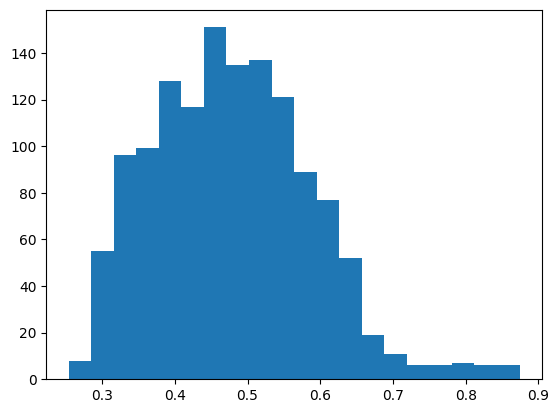

In [12]:
plt.hist(hand_strengths, bins = 20)
plt.show()